# Sampyo

1. classification model
2. 7class
3. 2.5% + 5%

## Import module

In [1]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import keras
import random

Using TensorFlow backend.
/home/cai/anaconda3/envs/MRCNN/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/cai/anaconda3/envs/MRCNN/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/cai/anaconda3/envs/MRCNN/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/cai/anaconda3/envs/MRCNN/l

## train data / test data

In [2]:
dataset_name = "./crop_dataset_water"

x_train = []
y_train = []
x_test = []
y_test = []

folder_list = os.listdir(dataset_name)
folder_list.sort()

In [3]:
folder_list

['FM_2.4_2.5%',
 'FM_2.4_5%',
 'FM_2.6_2.5%',
 'FM_2.6_5%',
 'FM_2.8_2.5%',
 'FM_2.8_5%',
 'FM_3.0_2.5%',
 'FM_3.0_5%',
 'FM_3.2_2.5%',
 'FM_3.2_5%',
 'FM_3.4_2.5%',
 'FM_3.4_5%',
 'FM_3.61_2.5%',
 'FM_3.61_5%']

In [4]:
folder_list25 = []
folder_list5 = []
for i in folder_list:
    if i[-3] == '.':
        folder_list25.append(i)
    else:
        folder_list5.append(i)

In [5]:
for one_folder in folder_list25:
    splited_one_folder =  one_folder.split("_")
    eveloped_one_folder = splited_one_folder[0]+"_"+splited_one_folder[1]
    # eveloped_one_folder : FM_classnum
    print(one_folder)
    
    join_folder_path = os.path.join(dataset_name, one_folder)
    # dataset folder path
    data_list = os.listdir(join_folder_path)
    # data list in folder
    
    ## train / test = 8:2
    test_list = random.sample(data_list, int(len(data_list) * 0.2))

    for one_data in data_list:
        
        join_data_path = os.path.join(join_folder_path, one_data)
        # each data path
        
        ### imread / resize / normalize
        img = cv2.imread(join_data_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (512,512))
        img = cv2.normalize(img, None, 0, 1, cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        img = np.reshape(img, (512,512,1)) # one channel

        # train
        if not one_data in test_list:
            # if data is not in test_list which is sampled before, add data in x_train, and class in y_train
            x_train.append(img)
            y_train.append(eveloped_one_folder)
            
        elif one_data in test_list:
            x_test.append(img)
            y_test.append(eveloped_one_folder)

            
tmp = [[x,y] for x,y in zip(x_train, y_train)]
random.shuffle(tmp)

x_train = [n[0] for n in tmp]
y_train = [n[1] for n in tmp]
            
x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)  
y_test = np.array(y_test)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

FM_2.4_2.5%
FM_2.6_2.5%


KeyboardInterrupt: 

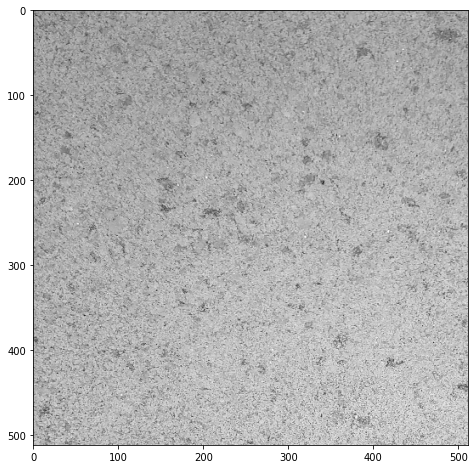

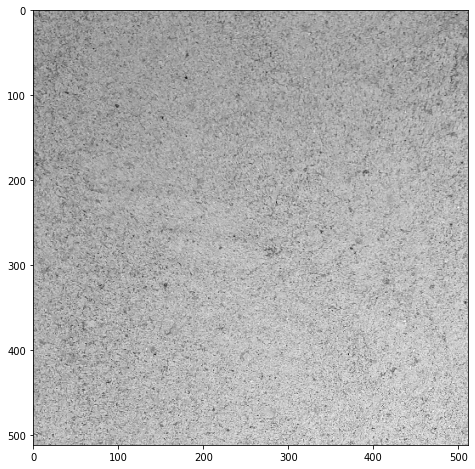

In [6]:
plt.figure(figsize=(8,8))
plt.imshow(x_train[1].reshape(512,512), cmap="gray")

plt.figure(figsize=(8,8))
plt.imshow(x_test[0].reshape(512,512), cmap="gray")

## Y data onehot encoding

* ex1) 2 -> [1,0,0,0,0,0]
* ex2) 7 -> [0,0,0,0,0,1]

In [7]:
from sklearn.preprocessing import OneHotEncoder

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

enc = OneHotEncoder()
enc.fit(y_train)

y_train_onehot = enc.transform(y_train).toarray()
y_test_onehot = enc.transform(y_test).toarray()

print(y_test_onehot)
print(y_test)

[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]
[['FM_2.4']
 ['FM_2.4']
 ['FM_2.4']
 ...
 ['FM_3.61']
 ['FM_3.61']
 ['FM_3.61']]


## Import keras module

In [8]:
import keras

from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Input
from keras.layers import Dropout
from keras.models import Model
from keras.callbacks import EarlyStopping
from keras.layers import BatchNormalization

from keras.utils import multi_gpu_model

from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

## Deep Learning Model

In [9]:
inputs = Input((512, 512, 1))

# Layer 1
x = Conv2D(filters = 128, kernel_size = 3, strides = 1, \
            padding = "same", activation = 'relu',kernel_initializer="glorot_normal")(inputs)
x = Conv2D(filters = 128, kernel_size = 3, strides = 1, \
            padding = "same", activation = 'relu',kernel_initializer="glorot_normal")(x)
x = MaxPooling2D(pool_size = 2, strides = 2)(x)

# Layer 2
x = Conv2D(filters = 128, kernel_size = 3, strides = 1, \
            padding = "same", activation = 'relu',kernel_initializer="glorot_normal")(x)
x = Conv2D(filters = 128, kernel_size = 3, strides = 1, \
            padding = "same", activation = 'relu',kernel_initializer="glorot_normal")(x)
x = MaxPooling2D(pool_size = 2, strides = 2)(x)

# Layer 3
x = Conv2D(filters = 128, kernel_size = 3, strides = 1, \
            padding = "same", activation = 'relu',kernel_initializer="glorot_normal")(x)
x = Conv2D(filters = 128, kernel_size = 3, strides = 1, \
            padding = "same", activation = 'relu',kernel_initializer="glorot_normal")(x)
x = MaxPooling2D(pool_size = 2, strides = 2)(x)

# Layer 4
x = Conv2D(filters = 128, kernel_size = 3, strides = 1, \
            padding = "same", activation = 'relu',kernel_initializer="glorot_normal")(x)
x = Conv2D(filters = 128, kernel_size = 3, strides = 1, \
            padding = "same", activation = 'relu',kernel_initializer="glorot_normal")(x)
x = Conv2D(filters = 128, kernel_size = 3, strides = 1, \
            padding = "same", activation = 'relu',kernel_initializer="glorot_normal")(x)
x = MaxPooling2D(pool_size = 2, strides = 2)(x)

# Layer 5
x = Conv2D(filters = 128, kernel_size = 3, strides = 1, \
            padding = "same", activation = 'relu',kernel_initializer="glorot_normal")(x)
x = Conv2D(filters = 128, kernel_size = 3, strides = 1, \
            padding = "same", activation = 'relu',kernel_initializer="glorot_normal")(x)
x = Conv2D(filters = 128, kernel_size = 3, strides = 1, \
            padding = "same", activation = 'relu',kernel_initializer="glorot_normal")(x)
x = MaxPooling2D(pool_size = 2, strides = 2)(x)

# Layer 6
x = Conv2D(filters = 128, kernel_size = 3, strides = 1, \
            padding = "same", activation = 'relu',kernel_initializer="glorot_normal")(x)
x = Conv2D(filters = 128, kernel_size = 3, strides = 1, \
            padding = "same", activation = 'relu',kernel_initializer="glorot_normal")(x)
x = Conv2D(filters = 128, kernel_size = 3, strides = 1, \
            padding = "same", activation = 'relu',kernel_initializer="glorot_normal")(x)
x = MaxPooling2D(pool_size = 2, strides = 2)(x)

# Layer 7
x = Conv2D(filters = 128, kernel_size = 3, strides = 1, \
            padding = "same", activation = 'relu',kernel_initializer="glorot_normal")(x)
x = Conv2D(filters = 128, kernel_size = 3, strides = 1, \
            padding = "same", activation = 'relu',kernel_initializer="glorot_normal")(x)
x = Conv2D(filters = 128, kernel_size = 3, strides = 1, \
            padding = "same", activation = 'relu',kernel_initializer="glorot_normal")(x)
x = MaxPooling2D(pool_size = 2, strides = 2)(x)

x = Flatten()(x)
x = Dense(128, activation = 'relu',kernel_initializer="glorot_normal")(x)
x = Dense(64, activation = 'relu',kernel_initializer="glorot_normal")(x)
outputs = Dense(7, activation = 'softmax',kernel_initializer="glorot_normal")(x)

model = Model(inputs=[inputs], outputs=[outputs])

#model.summary()
# keras.utils.vis_utils.plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

# from IPython.display import Image
# Image("model_plot.png")

Instructions for updating:
Colocations handled automatically by placer.


In [10]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 512, 512, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 512, 512, 128)     1280      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 512, 512, 128)     147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 256, 256, 128)     0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 256, 256, 128)     147584    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 256, 256, 128)     147584    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 128, 128, 128)     0         
__________

In [11]:
from sklearn.model_selection import train_test_split

x_train,x_val,y_train_onehot,y_val_onehot = train_test_split(x_train,y_train_onehot, test_size = 0.1, shuffle = True, random_state = 42)

In [12]:
#early stopping
early_stopping = keras.callbacks.EarlyStopping(monitor = 'val_loss', verbose = 0, patience = 10, mode = 'auto')

#checkpoint
checkpoint_path = './minyoung_checkpoint/cp--2.5%data--{epoch:04d}.ckpt'
cp_dir = os.path.dirname(checkpoint_path)
checkpoint_5epoch = keras.callbacks.ModelCheckpoint(checkpoint_path, save_weights_only = True, verbose = 1, period = 5)

## Learning

Instructions for updating:
Use tf.cast instead.
Train on 6920 samples, validate on 769 samples
Epoch 1/50
6920/6920 [==============================] - 173s 25ms/step - loss: 1.9440 - acc: 0.1574 - val_loss: 1.9405 - val_acc: 0.1586
Epoch 2/50
6920/6920 [==============================] - 168s 24ms/step - loss: 1.9420 - acc: 0.1559 - val_loss: 1.9374 - val_acc: 0.1586
Epoch 3/50
6920/6920 [==============================] - 168s 24ms/step - loss: 1.9411 - acc: 0.1497 - val_loss: 1.9401 - val_acc: 0.1586
Epoch 4/50
6920/6920 [==============================] - 168s 24ms/step - loss: 1.9411 - acc: 0.1552 - val_loss: 1.9396 - val_acc: 0.1586
Epoch 5/50
6920/6920 [==============================] - 168s 24ms/step - loss: 1.9412 - acc: 0.1565 - val_loss: 1.9391 - val_acc: 0.1586
Epoch 6/50
6920/6920 [==============================] - 168s 24ms/step - loss: 1.9408 - acc: 0.1546 - val_loss: 1.9403 - val_acc: 0.1678
Epoch 7/50
6920/6920 [==============================] - 168s 24ms/step - loss: 1.92

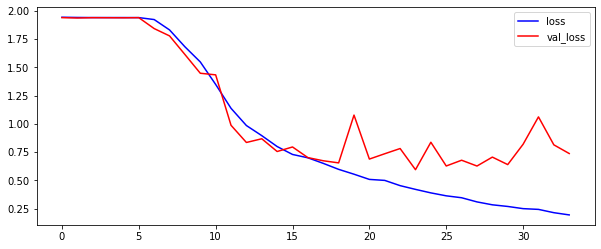

In [13]:
parallel_model = multi_gpu_model(model,gpus=2)

# callback
# early_stopping = EarlyStopping(monitor='val_loss',patience = 30)

# optimizer
adam = keras.optimizers.Adam(lr=0.00001)
parallel_model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

# fit model
hist = parallel_model.fit(x_train, y_train_onehot,\
                          epochs=50, batch_size=4,\
                          validation_data=(x_val, y_val_onehot),\
                         callbacks = [early_stopping, checkpoint_5epoch])

# plot loss & val_loss
plt.figure(figsize=(10,4))
plt.plot(hist.history['loss'],'b',label='loss')
plt.plot(hist.history['val_loss'],'r',label='val_loss')
plt.legend(loc="upper right");

# re train(only you need)

In [14]:
"""hist = parallel_model.fit(x_train, y_train_onehot,\
                          epochs=1, batch_size=4,\
                          validation_data=(x_test, y_test_onehot))

# plot loss & val_loss
plt.figure(figsize=(10,4))
plt.plot(hist.history['loss'],'b',label='loss')
plt.plot(hist.history['val_loss'],'r',label='val_loss')
plt.legend(loc="upper right");"""

'hist = parallel_model.fit(x_train, y_train_onehot,                          epochs=1, batch_size=4,                          validation_data=(x_test, y_test_onehot))\n\n# plot loss & val_loss\nplt.figure(figsize=(10,4))\nplt.plot(hist.history[\'loss\'],\'b\',label=\'loss\')\nplt.plot(hist.history[\'val_loss\'],\'r\',label=\'val_loss\')\nplt.legend(loc="upper right");'

## Predict

In [15]:
pred_y = parallel_model.predict(x_test)


In [16]:
y_test_onehot

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [17]:
pred_y = np.argmax(pred_y,axis=1 )
real_y = np.argmax(y_test_onehot,axis=1)

print(pred_y)
print(real_y)

[0 1 0 ... 6 3 4]
[0 0 0 ... 6 6 6]


In [18]:
corr_num1 = 0
corr_num2 = 0
for i in range(real_y.shape[0]):
    if pred_y[i] == real_y[i]: # prediction, gt same value
        corr_num1 += 1
        
    if abs(int(pred_y[i]) - int(real_y[i])) <= 1: # pred ~= gt ( threshold = 1 )
        corr_num2 += 1
        
print(corr_num1 / real_y.shape[0] * 100, "%")
print(corr_num2 / real_y.shape[0] * 100, "%")

75.88541666666667 %
91.5625 %


## Confusion Matrix

In [19]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(pred_y, real_y)

['2.4', '2.6', '2.8', '3.0', '3.2', '3.4', '3.61']


<AxesSubplot:>

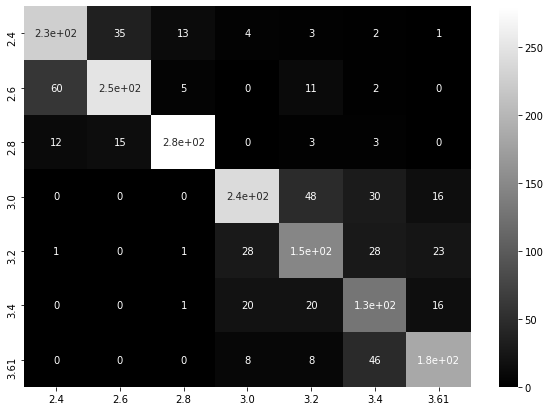

In [20]:
import seaborn as sn
import pandas as pd


cm_list = []
for one_folder in folder_list:
    splited_folder = one_folder.split("_")
    cm_list.append(splited_folder[1])
    cm_list = set(cm_list)
    cm_list = list(cm_list)
    cm_list.sort()
print(cm_list)
df_cm = pd.DataFrame(conf_mat, index = [i for i in cm_list],
                  columns = [i for i in cm_list])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, cmap="gray")

<AxesSubplot:>

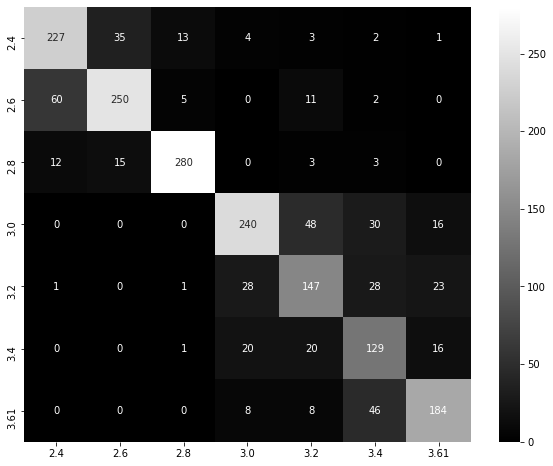

In [21]:
plt.figure(figsize = (10,8))
sn.heatmap(df_cm, annot=True, cmap="gray", fmt="g")

In [22]:
model.save("model_2.5percent_epoch50")